In [1]:
import pandas as pd
import numpy as np
import sys, os
import re
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import emoji
import pydot
import errno
from matplotlib import rcParams
%matplotlib inline 

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit import RDConfig
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from utility import FeatureGenerator
from rdkit.Chem import PandasTools as PandasTools
from rdkit import DataStructs
from rdkit.Chem.Subshape import SubshapeBuilder,SubshapeAligner,SubshapeObjects

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn import metrics
from sklearn import tree
from sklearn.svm import SVR
from pprint import pprint
pd.set_option('display.max_rows', None)

In [2]:
rcParams['figure.figsize'] = 5,5
rcParams['axes.linewidth'] = 2.0
rcParams['savefig.dpi'] = 500
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

In [3]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [4]:
data1=pd.read_csv("data1.csv", header=0, sep=',', engine='python')
data2=pd.read_csv("data2.csv", header=0, sep=',', engine='python')
tmp1rcsb=pd.read_csv("allrcsb.csv", header=0, sep=',', engine='python')
tmp2rcsb=pd.read_csv("PDE2-data.csv", header=0, sep=',', engine='python')
nonbinders=pd.read_csv("nonbind.csv", header=0, sep=',', engine='python')

rcsb=pd.merge(tmp1rcsb, tmp2rcsb, how='left', on='title')
tmp=pd.concat([data1, data2], axis=0, ignore_index=True)

In [5]:
col1_to_drop = ['ID-Number','Domain','Plate Position','Plate Amount [µg]','Total Molweight',
                'Run Number','Plate Number','MolWeight','H-Acceptors','H-Donors','Rotatable Bonds',
                'Log P','Log S','Chemical Name','MolWeight.1','QC Method','Purity','Purity [%]',
                'MoFormula','Molweight',]
tmp.drop(col1_to_drop, axis=1, inplace=True)


col2_to_drop = ['Rank','Dock Score','Exp']
rcsb.drop(col2_to_drop, axis=1, inplace=True)
combined=pd.concat([tmp, rcsb], axis=0, ignore_index=True)
combined=pd.concat([combined, nonbinders], axis=0, ignore_index=True)

In [6]:
combined['binder'] = np.where(combined['IC50'].isnull(), 0, 1)

In [7]:
#missing values in columns
combined.isnull().sum(axis=0)

title       0
IC50      210
SMILES      0
binder      0
dtype: int64

In [8]:
rcsb.isnull().sum(axis=0)

SMILES    0
title     0
IC50      0
dtype: int64

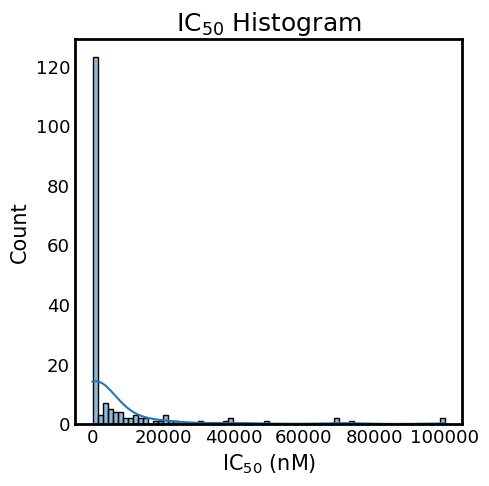

In [9]:
sns.histplot(combined['IC50'], kde=True, linewidth=1)
plt.title('IC$_{50}$ Histogram', fontsize=18)
plt.xlabel("IC$_{50}$ (nM)", fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tick_params(which='both',direction='in',length=0, width=3,)

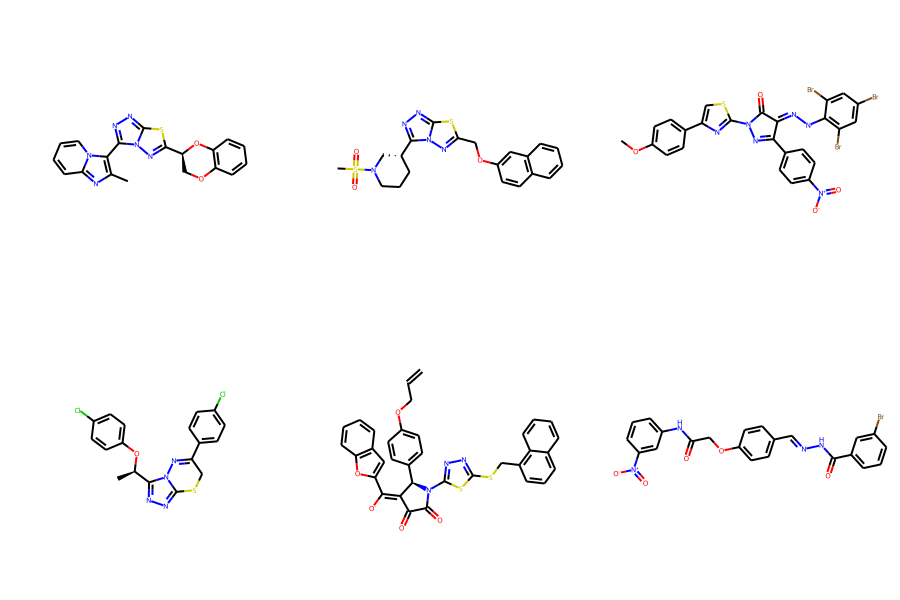

In [10]:
#Convert SMILES to 2D molecules:
molecules = combined.SMILES.apply(Chem.MolFromSmiles)
Draw.MolsToGridImage(molecules[:6],molsPerRow=3, subImgSize=(300, 300))

Tanimoto Similarity Coefficient of molecule_1 vs molecule_1: 1.0
Tanimoto Similarity Coefficient of molecule_1 vs molecule_2: 0.20430107526881722


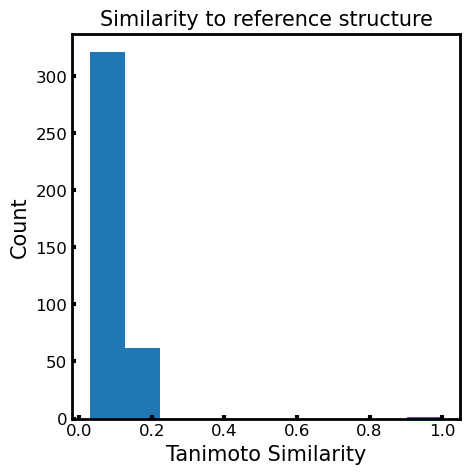

In [11]:
## Similarity Calculations

# We calculate Morgan fingerprints 
mols_fps=[AllChem.GetMorganFingerprintAsBitVect(x,2) for x in molecules]
print(f'Tanimoto Similarity Coefficient of molecule_1 vs molecule_1: {DataStructs.TanimotoSimilarity(mols_fps[0],mols_fps[0])}')
print(f'Tanimoto Similarity Coefficient of molecule_1 vs molecule_2: {DataStructs.TanimotoSimilarity(mols_fps[0],mols_fps[1])}')

# Calculate similarities to reference molecule
sim_ref = DataStructs.BulkTanimotoSimilarity(mols_fps[0],mols_fps)


# Calculate pairwise similarities
def pairwise_sim(mols):
    pairwise=[]
    for i in mols:
        sim = DataStructs.BulkTanimotoSimilarity(i,mols)
        pairwise.append(sim)
    return pairwise

PW = pairwise_sim(mols_fps)
plt.hist(sim_ref)
plt.title('Similarity to reference structure', fontsize=15)
plt.xlabel('Tanimoto Similarity', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(which='both',direction='in',length=3, width=3,)

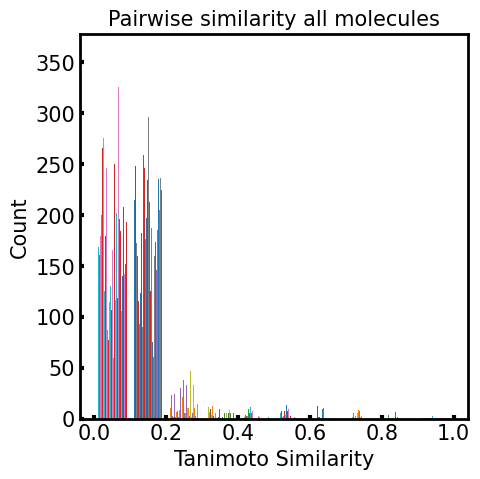

In [12]:
plt.hist(PW)
plt.title('Pairwise similarity all molecules', fontsize=15)
plt.xlabel('Tanimoto Similarity', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tick_params(which='both',direction='in',length=3, width=3,)

In [13]:
combined.loc[:, 'MolLogP'] = molecules.apply(Descriptors.MolLogP)
combined.loc[:, 'HeavyAtomCount'] = molecules.apply(Descriptors.HeavyAtomCount)
combined.loc[:, 'HAccept'] = molecules.apply(Descriptors.NumHAcceptors)
combined.loc[:, 'Heteroatoms'] = molecules.apply(Descriptors.NumHeteroatoms)
combined.loc[:, 'HDonor'] = molecules.apply(Descriptors.NumHDonors)
combined.loc[:, 'MolWt'] = molecules.apply(Descriptors.MolWt)
combined.loc[:, 'RotableBonds'] = molecules.apply(Descriptors.NumRotatableBonds)
combined.loc[:, 'RingCount'] = molecules.apply(Descriptors.RingCount)
combined.loc[:, 'Ipc'] = molecules.apply(Descriptors.Ipc)
combined.loc[:, 'HallKierAlpha'] = molecules.apply(Descriptors.HallKierAlpha)
combined.loc[:, 'NumValenceElectrons'] = molecules.apply(Descriptors.NumValenceElectrons)
combined.loc[:, 'SaturatedRings'] = molecules.apply(Descriptors.NumSaturatedRings)
combined.loc[:, 'AliphaticRings'] = molecules.apply(Descriptors.NumAliphaticRings)
combined.loc[:, 'AromaticRings'] = molecules.apply(Descriptors.NumAromaticRings)

In [14]:
combined.describe()

,IC50,binder,MolLogP,HeavyAtomCount,HAccept,Heteroatoms,HDonor,MolWt,RotableBonds,RingCount,Ipc,HallKierAlpha,NumValenceElectrons,SaturatedRings,AliphaticRings,AromaticRings
count,174.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,3.840000e+02,384.000000,384.000000,384.000000,384.000000,384.000000
mean,5891.046449,0.453125,2.903532,23.575521,4.882812,7.158854,0.973958,339.154065,3.760417,3.088542,1.273702e+08,-2.573984,121.796875,0.369792,0.739583,2.348958
std,15647.984052,0.498447,1.726319,7.281690,2.018017,2.441648,0.878730,105.811012,1.842321,1.415127,1.774319e+09,0.902015,37.130711,0.649341,0.833312,1.199695
min,0.500000,0.000000,-1.830300,12.000000,1.000000,2.000000,0.000000,163.176000,0.000000,1.000000,3.195721e+02,-5.540000,62.000000,0.000000,0.000000,0.000000
25%,9.587444,0.000000,1.781675,17.000000,3.000000,5.000000,0.000000,241.552500,3.000000,2.000000,6.988807e+03,-3.230000,87.000000,0.000000,0.000000,1.000000
50%,124.657715,0.000000,2.982150,24.000000,5.000000,7.000000,1.000000,344.061000,4.000000,3.000000,3.897608e+05,-2.565000,126.000000,0.000000,1.000000,2.000000
75%,4025.000000,1.000000,3.740805,30.000000,6.000000,9.000000,2.000000,422.824000,5.000000,4.000000,6.957160e+06,-1.850000,154.000000,1.000000,1.000000,3.000000
max,100000.000000,1.000000,8.702700,45.000000,11.000000,16.000000,4.000000,734.204000,11.000000,8.000000,3.373991e+10,-0.190000,236.000000,4.000000,4.000000,6.000000


In [15]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   title                384 non-null    object 
 1   IC50                 174 non-null    float64
 2   SMILES               384 non-null    object 
 3   binder               384 non-null    int64  
 4   MolLogP              384 non-null    float64
 5   HeavyAtomCount       384 non-null    int64  
 6   HAccept              384 non-null    int64  
 7   Heteroatoms          384 non-null    int64  
 8   HDonor               384 non-null    int64  
 9   MolWt                384 non-null    float64
 10  RotableBonds         384 non-null    int64  
 11  RingCount            384 non-null    int64  
 12  Ipc                  384 non-null    float64
 13  HallKierAlpha        384 non-null    float64
 14  NumValenceElectrons  384 non-null    int64  
 15  SaturatedRings       384 non-null    int

In [16]:
combined['binder'].value_counts()

0    210
1    174
Name: binder, dtype: int64

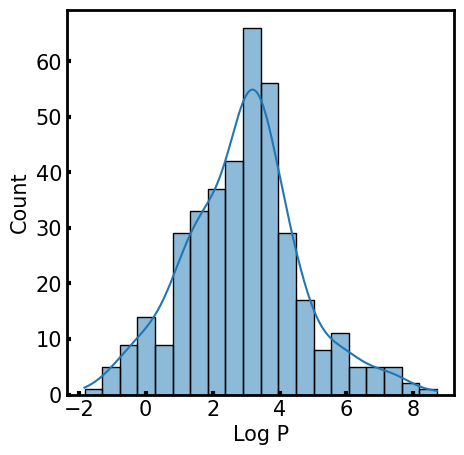

In [17]:
sns.histplot(combined['MolLogP'], kde=True, linewidth=1)
plt.xlabel('Log P', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tick_params(which='both',direction='in',length=3, width=3,)

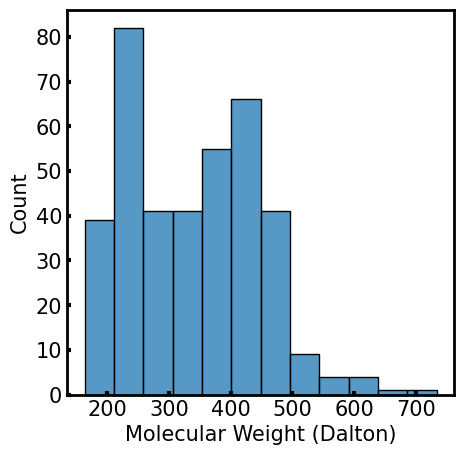

In [18]:
sns.histplot(combined['MolWt'], linewidth=1)
plt.xlabel('Molecular Weight (Dalton)', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tick_params(which='both',direction='in',length=3, width=3,)

In [19]:
X = combined.iloc[:, 4:]
y = np.array(combined['binder'])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
from sklearn.preprocessing import StandardScaler

ss_train = StandardScaler()
X_train = ss_train.fit_transform(X_train)

ss_test = StandardScaler()
X_test = ss_test.fit_transform(X_test)

In [22]:
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression()

# Support Vector Machines
from sklearn.svm import LinearSVC
models['Support Vector Machines'] = LinearSVC()

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['Decision Trees'] = DecisionTreeClassifier()

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier()

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
models['Naive Bayes'] = GaussianNB()

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
models['K-Nearest Neighbor'] = KNeighborsClassifier()

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy, precision, recall = {}, {}, {}

for key in models.keys():
    
    # Fit the classifier
    models[key].fit(X_train, y_train)
    
    # Make predictions
    predictions = models[key].predict(X_test)
    
    # Calculate metrics
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test)
    recall[key] = recall_score(predictions, y_test)

/home/chuck/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [24]:
df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()

df_model

,Accuracy,Precision,Recall
Logistic Regression,0.818182,0.750000,0.916667
Support Vector Machines,0.818182,0.750000,0.916667
Decision Trees,0.428571,0.090909,0.500000
Random Forest,0.818182,0.704545,0.968750
Naive Bayes,0.831169,0.750000,0.942857
K-Nearest Neighbor,0.831169,0.750000,0.942857


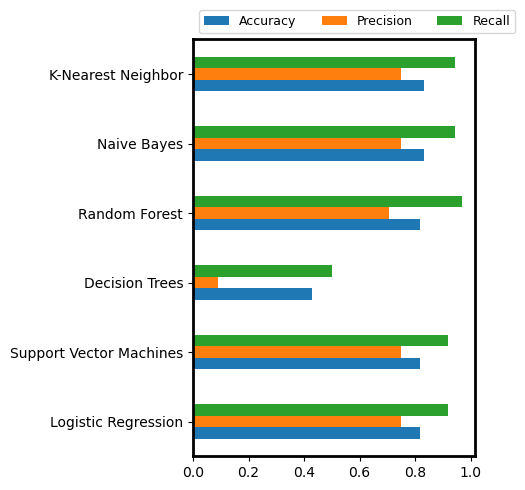

In [25]:
df_model.plot.barh()
plt.legend(
    ncol=len(models.keys()), 
    bbox_to_anchor=(0, 1), 
    loc='lower left', 
    prop={'size': 9})
plt.tight_layout()